# Milestone II Companion Notebook - Unsupervised Learning with LSA and LDA
## By Laura Stagnaro and Sean Cafferty

## Table of Contents
1. Latent Semantic Analysis
2. Latent Dirichlet Allocation
3. Network Analysis of Word Embeddings

In [22]:
## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import GridSearchCV
import texthero as hero

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt


%matplotlib inline

In [4]:
#Custom Modules

from nlpeeps import feature_engine
from viz_engine import viz_engine
from unsupervised_engine import unsupervised_engine

In [47]:
## ++++ WARNING! ++++++

## The CSV of preprocessed was too large to store in the GitHub. 
## The preprocessed data can be recreated by running the 'preprocessing' notebook available in the Github repository. 

## Also, the original WikiTrain_Large.csv will also run in this notebook

In [6]:
# Get the data
file = pd.read_csv('assets/wiki_train_preprocessed5.csv', encoding='utf-8')

SAMPLE_SIZE =100000

np.random.seed(911)
df = file.sample(SAMPLE_SIZE)

## **1. Latent Semantic Analysis**

In order to examine the underlying structure of the data, we sought to perform topic modeling with latent semantic analysis techniques.

In [42]:
unsupervised_engine.choices()

['preprocess_data', 'prepare_data', 'create_LSA', 'get_coherence_values']

## *1.1 Preprocess Data and Train Model*

In [7]:
text_list = unsupervised_engine.preprocess_data(df['original_text'])

100%|██████████| 100000/100000 [00:19<00:00, 5179.53it/s]


In [8]:
model = unsupervised_engine.create_LSA(text_list, 10, 10)

In [9]:
topic_words = {}
for topic in model.print_topics(num_topics=16, num_words=20):
    topic = str(topic).split(',')
    topic_num = topic[0][1:]
    words = re.findall('"(.*?)"', topic[1:][0])
    topic_words[topic_num] = words

In [10]:
#unsupervised_engine.get_coherence_values(text_list,stop=20,step=2)

## *1.2 Evaluate Results*

### Although our results yielded some interesting patterns, human observers would likely not consider these topics particularly coherent. Nonetheless, Topic 1 appears to have a large number of words that pertain to France, while Topic 0 seems to pertain to both America and sports. 

#### **Topic 0:** ['rrb', 'lrb', 'born', 'footbal', 'known', 'also', '1', 'state', 'american', 'unit', 'one', 'player', 'name', 'use', 'first', 'â', 'play', '2', 'year', '4']

#### **Topic 1:** ['franc', 'de', 'depart', 'region', 'commun', 'pa', 'calai', 'found', 'north', 'nord', 'la', 'aisn', 'picardi', 'calvado', 'loir', 'bass', 'normandi', 'pay', 'northern', 'saint']

In [11]:
for topic in topic_words:
    print("Topic {}: {}".format(topic, str(topic_words[topic])))
    print()

Topic 0: ['rrb', 'lrb', 'born', 'footbal', 'known', 'also', '1', 'state', 'american', 'unit', 'one', 'player', 'name', 'use', 'first', 'â', 'play', '2', 'year', '4']

Topic 1: ['franc', 'de', 'depart', 'region', 'commun', 'pa', 'calai', 'found', 'north', 'nord', 'la', 'aisn', 'picardi', 'calvado', 'loir', 'bass', 'normandi', 'pay', 'northern', 'saint']

Topic 2: ['state', 'unit', 'citi', 'first', 'one', 'use', 'also', 'counti', 'new', 'rrb', 'lrb', 'world', 'name', 'nation', 'year', 'known', 'two', 'time', '1', 'part']

Topic 3: ['state', 'footbal', 'unit', 'born', 'first', 'play', 'one', 'use', 'also', 'citi', 'player', 'team', 'known', 'year', 'name', 'nation', 'game', 'world', 'time', 'two']

Topic 4: ['born', 'footbal', 'use', 'player', 'also', 'one', 'play', 'state', 'unit', 'former', 'first', 'nation', 'team', 'name', 'year', 'two', 'leagu', 'japanes', 'call', 'time']

Topic 5: ['use', 'first', '1', 'also', '4', '2', 'year', 'de', 'one', 'ð', 'pa', 'calai', '3', 'footbal', 'î', '

# **2. Latent Dirichlet Allocation**

### Given that the results of the Latent Semantic Analysis were not particularly robust, we sought to analyze the results of Latent Dirichlet Allocation techniques as well. 

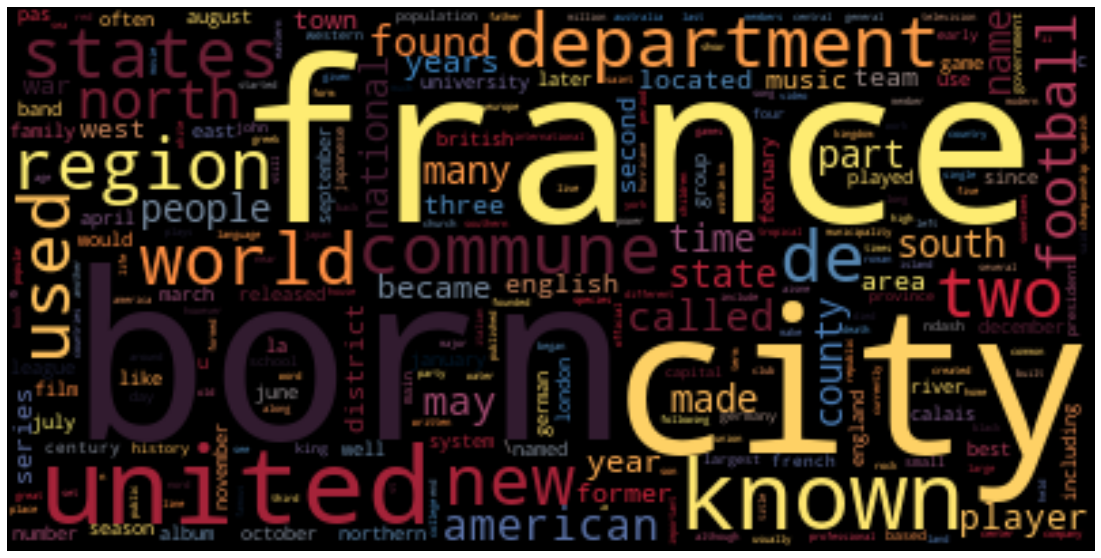

In [12]:
viz_engine.simple_wordcloud(df,'black')

## *2.1 Preprocess Data for LDA*

In [13]:
text_list = unsupervised_engine.preprocess_data(df['original_text'])

100%|██████████| 100000/100000 [00:18<00:00, 5417.47it/s]


In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))
data_words = list(sent_to_words(text_list))

In [15]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## *2.2 Vectorize Text Data*

In [16]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        
                             stop_words='english',            
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}') 
                            
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [17]:
lda_model = LatentDirichletAllocation(n_components= 6,               # Number of topics
                                      max_iter= 10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128)                # n docs in each learning iter
                                            
lda_output = lda_model.fit_transform(data_vectorized)                                    

In [18]:
print("Log Likelihood: ", lda_model.score(data_vectorized))
print("Perplexity: ", lda_model.perplexity(data_vectorized))


Log Likelihood:  -7020410.511503373
Perplexity:  2644.247671508107


In [19]:
pyLDAvis.enable_notebook()
panel1 = pyLDAvis.sklearn.prepare(lda_model,data_vectorized,vectorizer,mds='tsne')

In [51]:
#panel1

## *2.3 Optimize LDA with Grid Search*

### Given the lack of coherence of our LDA results, we sought to optimize them with GridSearch techniques. 

In [21]:
params = {'n_components':[2,5,8,12],'learning_decay':[0.5,0.7,0.9]}
lda= LatentDirichletAllocation()
model=GridSearchCV(lda, param_grid=params)


model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 5, 8, 12]})

In [22]:
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_ )
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 2}
Best Log Likelihood Score:  -1406163.960453016
Model Perplexity:  2273.2708151706265


In [50]:
pyLDAvis.enable_notebook()
panel2 = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
#panel2

In [24]:
def show_topics (vectorizer=vectorizer, lda_model=lda_model, n_words = 20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic ' + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,rrb,lrb,bear,state,unit,footbal,play,american,nation,year
Topic 1,use,franc,commun,depart,region,make,north,peopl,citi,south


### Ultimately, the grid search yielded only two topics that were deemed mathematically coherent. Though few topics were present, it seems that both topics are rather logical. Again, one topic refers to France while the other topic somewhat refers to what might be considered 'American Sports' themes.

## *3. Network Visualization of Word Embeddings*

### We were interested to see whether the results from our topic modeling are visible in the word embeddings generated from the dataset. As such, we used Networkx and Plotly to generate a network of common interrelated vocabulary within the data. This data exploration technique revealed that there are indeed clusters of common vocabulary related to the topics identified by the unsupervised learning techniques. Thus, although few robust topics are present in the data, there does seem to be a semantic skew towards France- and America-related topics, leading us to conclude that articles regarding these topics are rather overrepresented in the dataset. 

In [ ]:
#word_embedder.word_embedder(df,'WikiTrain_Large_WordEmbeddings_model')

In [30]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec.load('custom_word_embeddings/WikiTrain_Large_WordEmbeddings_model.bin')


In [32]:
viz_engine.choices()

['histogrammer',
 'float_histogrammer',
 'word_embeddings_matrix',
 'word_embeddings_network',
 'pos_ratio_barchart',
 'adar_staticTreemap',
 'adar_interactiveTreemapsimple_wordcloud']

In [40]:
from viz_engine5 import viz_engine

In [41]:
viz_engine.word_embeddings_network(model,1000,.65,'text')

'result.html'

## Resources Used:
* https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34 
* https://opendatascience.com/unsupervised-learning-how-i-learned-to-love-the-data/ 
* https://highdemandskills.com/topic-modeling-lda/ 
* https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d 
* https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547
* https://thirdeyedata.io/topic-modeling-and-latent-dirichlet-allocation-lda-in-python/
* https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
* https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
* https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05
* https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
* https://shravan-kuchkula.github.io/topic-modeling/#data-gathering-and-normalization 
* https://plotly.com/python/network-graphs/
* https://www.coursera.org/projects/interactive-word2vec
* https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
* https://www.coursera.org/projects/optimization-of-topic-models-using-grid-search-method
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

## Thanks!